## Batch opening IMOS Data

In [1]:
import urllib
import io, re
import numpy as np
import struct
import matplotlib.pyplot as plt
import s3fs
import dask
import pandas as pd
from dask.diagnostics import ProgressBar
import hvplot.pandas

In [2]:
# Function to read binary data and fetch header

@dask.delayed (nout=3)
def ReadBinaryFile(file):
    
    with s3.open(file) as f:
        data = f.readlines() 
    
    # Split binary file
    header, body, footer = data[:5], data[5:-6], data[-6:]

    # Fetch header info with # https://regex101.com/
    header = [h.decode() for h in header]
    match = re.match('Sample Rate ([0-9]*) Duration ([0-9]*)', header[2])
    SampleRate = int(match.group(1))
    Duration = int(match.group(2))
    match = re.match('Schedule [0-9]* ([0-9]{4})\/([0-9]{2})\/([0-9]{1,2}) ([0-9:]*) - ([0-9]*)', header[1])
    match.groups()

    # Read binaries
    list_of_bytes = [bytes(element) for element in body]
    list_of_bytes = b'<\>'.join(list_of_bytes)
    new_body = []

    for i, l in enumerate(body):
        if len(l)%2 == 1:
            #print(l, i)
            l = l[:-1]
        string_formatter = '>' + ('H' * (len(l) // 2))
        temp = struct.unpack(string_formatter, l)
        new_body.extend(temp)
    
    volts = np.array(new_body)
    
    #Convert to actual Volts
    Fullscale = 5 #	0 to 5 V
    #Multiply by this factor to convert A/D counts to volts 0-5
    CountsToVolts = Fullscale / 65536 

    Volts = (CountsToVolts * volts) - np.mean(volts * CountsToVolts)
    
    return Volts, Duration, SampleRate

In [3]:
# Fetch all urls
s3 = s3fs.S3FileSystem(anon=True)

# List the files available
audio_files = s3.ls("imos-data/IMOS/ANMN/Acoustic/PAPCA/3444/20161002/raw/")

In [4]:
output_amp, output_dur, output_sr = ([] for i in range(3))
for f in audio_files:
    Volts, duration, SampleRate = ReadBinaryFile(audio_files[0])
    output_amp.append(Volts)
    output_dur.append(duration)
    output_sr.append(SampleRate)

In [5]:
with ProgressBar():
    output_amp, output_dur, output_sr = dask.compute(output_amp, output_dur, output_sr)

[########################################] | 100% Completed | 26.94 s


In [6]:
output_amp_tot = np.concatenate(output_amp)
output_duration_tot = sum(output_dur)

In [7]:
output_amp_tot.dtype

dtype('float64')

In [8]:
# transform np array to pandas
output_amp_tot = pd.Series(output_amp_tot)

In [9]:
output_amp_tot.shape

(176836416,)

In [14]:
output_amp_tot[::10].hvplot.scatter(rasterize=True)

:DynamicMap   []
   :Image   [index,0]   (index_0 Count)

In [11]:
SampleRate.compute()

6000

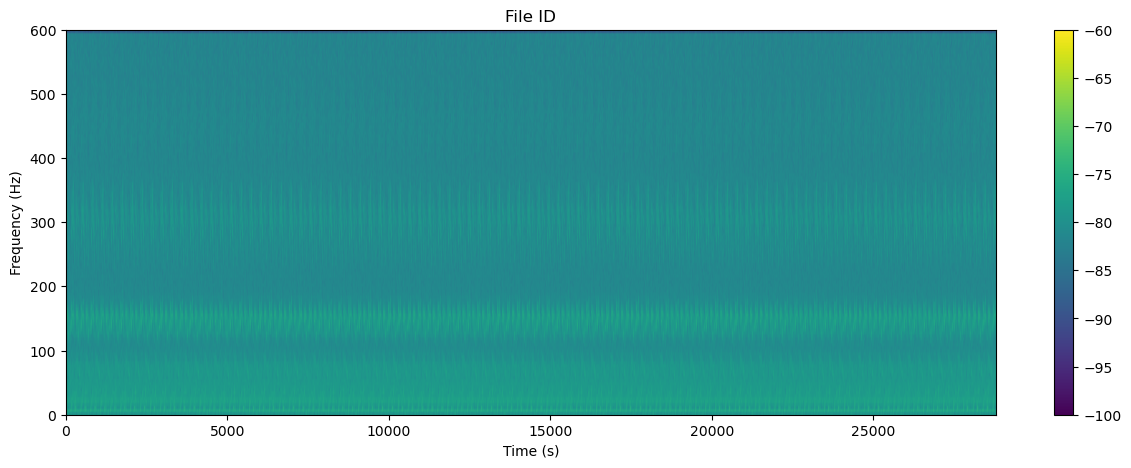

In [13]:
# Plot spectrogram
plt.figure(figsize=(15, 5))
plt.specgram(output_amp_tot[::5], Fs=1200, vmin = -100, vmax= -60)
plt.title('File ID')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, output_duration_tot)
plt.colorbar()
plt.show()